In [2]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [5]:
df1 = pd.read_csv('./HealthClaims/Train_Inpatientdata.csv')
df11 = pd.read_csv('./HealthClaims/Train_Outpatientdata.csv')
df2 = pd.read_csv('./HealthClaims/Train_Beneficiarydata.csv')
df3 = pd.read_csv('./HealthClaims/TrainFraud.csv')

FileNotFoundError: [Errno 2] No such file or directory: './HealthClaims/Train_Inpatientdata.csv'

In [3]:
# List of columns to remove
mismatched_columns = ['DiagnosisGroupCode', 'AdmissionDt', 'DischargeDt']

# Remove the mismatched columns from df1
df1_1 = df1.drop(columns=mismatched_columns)

In [4]:
dfc = pd.concat([df1_1,df11],axis=0)

In [5]:
dfm = pd.merge(dfc, df3, on='Provider', how='left')
dfm = pd.merge(df2, dfm, on='BeneID', how='left')
dfm['PotentialFraud'] = dfm['PotentialFraud'].replace({'Yes': 1, 'No': 0})

In [6]:
# Selecting only the specified columns from df1
df1_subset = df1[['BeneID', 'DiagnosisGroupCode', 'AdmissionDt', 'DischargeDt']]

# Merging df1_subset with dfm based on the 'BeneID' column
dfm1 = pd.merge(dfm, df1_subset, on='BeneID', how='inner')

In [7]:
for col in df1.columns:
    if col not in dfm.columns:
        dfm[col] = df1[col]

In [8]:
# Convert 'DOB' and 'ClaimStartDt' to datetime objects
dfm['DOB'] = pd.to_datetime(dfm['DOB'])
dfm['ClaimStartDt'] = pd.to_datetime(dfm['ClaimStartDt'])
dfm['ClaimEndDt'] = pd.to_datetime(dfm['ClaimEndDt'])

# Calculate ClaimSettleTime in days
dfm['ClaimSettleTime'] = (dfm['ClaimEndDt'] - dfm['ClaimStartDt']).dt.days

# Calculate age at the time of filing the claim
dfm['Age'] = ((dfm['ClaimStartDt'] - dfm['DOB']).dt.days / 365).astype(int)

In [9]:
drop_cols = ['ClmDiagnosisCode_3','OperatingPhysician', 'OtherPhysician', 'ClmAdmitDiagnosisCode','BeneID', 'DOD', 'DOB','ClaimID', 'ClmDiagnosisCode_4', 'ClmDiagnosisCode_5', 'ClmDiagnosisCode_6', 'ClmDiagnosisCode_7', 'ClmDiagnosisCode_8','ClmDiagnosisCode_9', 'ClmDiagnosisCode_10', 'ClmProcedureCode_1', 'ClmProcedureCode_2', 'ClmProcedureCode_3', 'ClmProcedureCode_4', 'ClmProcedureCode_5', 'ClmProcedureCode_6', 'AdmissionDt', 'DischargeDt', 'DiagnosisGroupCode', 'ClaimStartDt', 'ClaimEndDt']

In [10]:
dfm1=dfm.drop(drop_cols,axis=1)

In [11]:
dfm1['RenalDiseaseIndicator'] = dfm1['RenalDiseaseIndicator'].replace({'Y': 1, '0': 0})
# Convert the 'RenalDiseaseIndicator' column to integer
dfm1['RenalDiseaseIndicator'] = dfm1['RenalDiseaseIndicator'].astype(int)

In [12]:
# Remove 'PRV' prefix from the 'Provider' column
dfm1['Provider'] = dfm1['Provider'].str.replace('PRV', '')
dfm1['AttendingPhysician'] = dfm1['AttendingPhysician'].str.replace('PHY', '')

# Convert the 'Provider' column to integer type
dfm1['Provider'] = dfm1['Provider'].astype(int)
# dfm1['AttendingPhysician'] = dfm1['AttendingPhysician'].astype(int)


In [13]:
from sklearn.impute import SimpleImputer

# Select columns with object data type
object_columns = dfm1.select_dtypes(include='object').columns
print(object_columns)
# Create a SimpleImputer instance
imputer = SimpleImputer(strategy='most_frequent')

# Fit the imputer on the data
imputer.fit(dfm1[object_columns])

# Impute missing values
dfm1[object_columns] = imputer.transform(dfm1[object_columns])


Index(['AttendingPhysician', 'ClmDiagnosisCode_1', 'ClmDiagnosisCode_2'], dtype='object')


In [14]:
dfm1['DeductibleAmtPaid']=dfm1['DeductibleAmtPaid'].fillna(0.0)

In [15]:
from sklearn.preprocessing import LabelEncoder

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Iterate over each column in the DataFrame
for column in dfm1.select_dtypes(include=['object']).columns:
    # Encode the column
    dfm1[column] = label_encoder.fit_transform(dfm1[column])

In [16]:
dfm1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 558211 entries, 0 to 558210
Data columns (total 31 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   Gender                           558211 non-null  int64  
 1   Race                             558211 non-null  int64  
 2   RenalDiseaseIndicator            558211 non-null  int32  
 3   State                            558211 non-null  int64  
 4   County                           558211 non-null  int64  
 5   NoOfMonths_PartACov              558211 non-null  int64  
 6   NoOfMonths_PartBCov              558211 non-null  int64  
 7   ChronicCond_Alzheimer            558211 non-null  int64  
 8   ChronicCond_Heartfailure         558211 non-null  int64  
 9   ChronicCond_KidneyDisease        558211 non-null  int64  
 10  ChronicCond_Cancer               558211 non-null  int64  
 11  ChronicCond_ObstrPulmonary       558211 non-null  int64  
 12  Ch

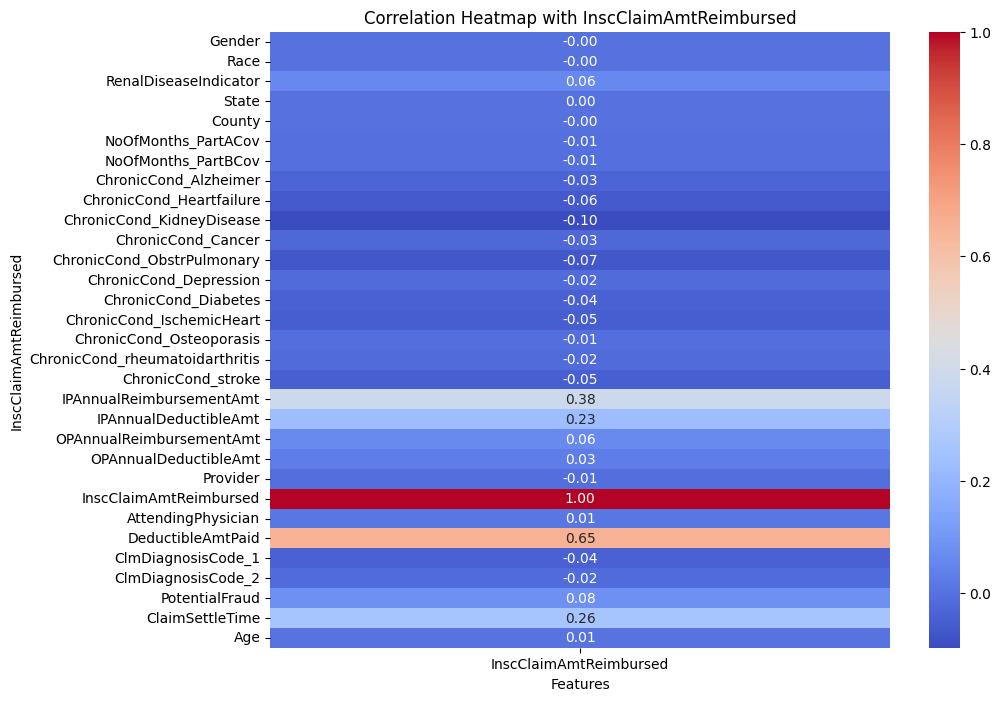

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the correlation matrix
corr_matrix = dfm1.corr()

# Filter the correlation matrix for 'InscClaimAmtReimbursed'
corr_with_target = corr_matrix['InscClaimAmtReimbursed']

# Plot th heatmapTrue
plt.figure(figsize=(10, 8))
sns.heatmap(corr_with_target.to_frame(), cmap='coolwarm', annot=True, fmt=".2f")
plt.title('Correlation Heatmap with InscClaimAmtReimbursed')
plt.xlabel('Features')
plt.ylabel('InscClaimAmtReimbursed')
plt.show()


In [18]:
# Replace 2 with 0 in the specified columns
chronic_columns = ['ChronicCond_Alzheimer', 'ChronicCond_Heartfailure', 'ChronicCond_KidneyDisease',
                      'ChronicCond_Cancer', 'ChronicCond_ObstrPulmonary', 'ChronicCond_Depression',
                      'ChronicCond_Diabetes', 'ChronicCond_IschemicHeart', 'ChronicCond_Osteoporasis',
                      'ChronicCond_rheumatoidarthritis', 'ChronicCond_stroke']
dfm2=dfm1
dfm2[chronic_columns] = dfm2[chronic_columns].replace(2, 0)



In [19]:
# Sum up the values of each row in the specified columns
dfm2['ChronicCondLevel'] = dfm2[chronic_columns].sum(axis=1)

# Drop the specified columns
dfm2.drop(columns=chronic_columns, inplace=True)


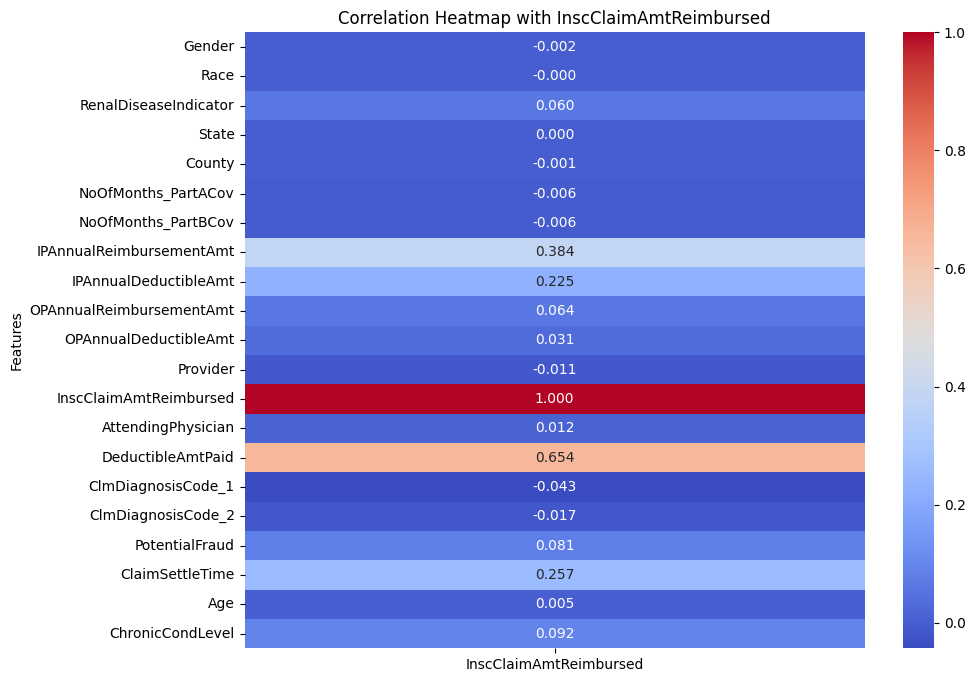

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the correlation matrix
corr_matrix = dfm1.corr()

# Filter the correlation matrix for 'InscClaimAmtReimbursed'
corr_with_target = corr_matrix['InscClaimAmtReimbursed']

# Plot th heatmapTrue
plt.figure(figsize=(10, 8))
sns.heatmap(corr_with_target.to_frame(), cmap='coolwarm', annot=True, fmt=".3f")
plt.title('Correlation Heatmap with InscClaimAmtReimbursed')
plt.ylabel('Features')
plt.show()


In [21]:
# Set the threshold
threshold = 0.01

# Filter the correlation values below the threshold
filtered_corr = corr_with_target[abs(corr_with_target) >= threshold]

# Get the list of columns
filtered_columns = filtered_corr.index.tolist()

# Print the list of colum
print(filtered_columns)


['RenalDiseaseIndicator', 'IPAnnualReimbursementAmt', 'IPAnnualDeductibleAmt', 'OPAnnualReimbursementAmt', 'OPAnnualDeductibleAmt', 'Provider', 'InscClaimAmtReimbursed', 'AttendingPhysician', 'DeductibleAmtPaid', 'ClmDiagnosisCode_1', 'ClmDiagnosisCode_2', 'PotentialFraud', 'ClaimSettleTime', 'ChronicCondLevel']


In [22]:
dfm3 = dfm2[filtered_columns]

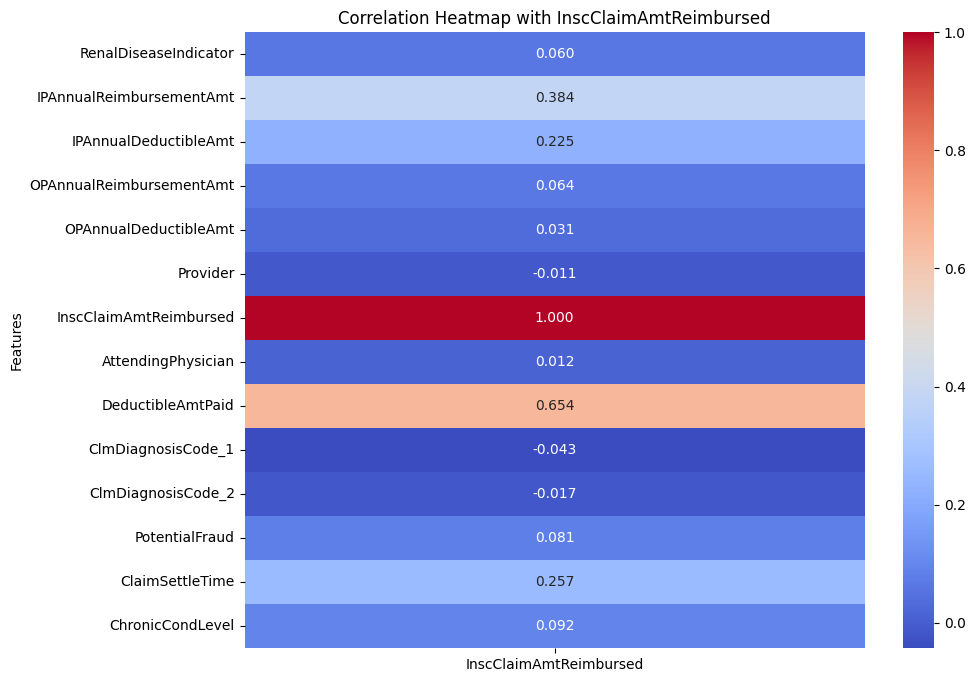

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the correlation matrix
corr_matrix = dfm3.corr()

# Filter the correlation matrix for 'InscClaimAmtReimbursed'
corr_with_target = corr_matrix['InscClaimAmtReimbursed']

# Plot th heatmapTrue
plt.figure(figsize=(10, 8))
sns.heatmap(corr_with_target.to_frame(), cmap='coolwarm', annot=True, fmt=".3f")
plt.title('Correlation Heatmap with InscClaimAmtReimbursed')
plt.ylabel('Features')
plt.show()


In [24]:
dfm3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 558211 entries, 0 to 558210
Data columns (total 14 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   RenalDiseaseIndicator     558211 non-null  int32  
 1   IPAnnualReimbursementAmt  558211 non-null  int64  
 2   IPAnnualDeductibleAmt     558211 non-null  int64  
 3   OPAnnualReimbursementAmt  558211 non-null  int64  
 4   OPAnnualDeductibleAmt     558211 non-null  int64  
 5   Provider                  558211 non-null  int32  
 6   InscClaimAmtReimbursed    558211 non-null  int64  
 7   AttendingPhysician        558211 non-null  int32  
 8   DeductibleAmtPaid         558211 non-null  float64
 9   ClmDiagnosisCode_1        558211 non-null  int32  
 10  ClmDiagnosisCode_2        558211 non-null  int32  
 11  PotentialFraud            558211 non-null  int64  
 12  ClaimSettleTime           558211 non-null  int64  
 13  ChronicCondLevel          558211 non-null  i

In [25]:
dfm3.to_csv('./HealthClaims/finalized.csv',index=False)

In [26]:
df = dfm3
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 558211 entries, 0 to 558210
Data columns (total 14 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   RenalDiseaseIndicator     558211 non-null  int32  
 1   IPAnnualReimbursementAmt  558211 non-null  int64  
 2   IPAnnualDeductibleAmt     558211 non-null  int64  
 3   OPAnnualReimbursementAmt  558211 non-null  int64  
 4   OPAnnualDeductibleAmt     558211 non-null  int64  
 5   Provider                  558211 non-null  int32  
 6   InscClaimAmtReimbursed    558211 non-null  int64  
 7   AttendingPhysician        558211 non-null  int32  
 8   DeductibleAmtPaid         558211 non-null  float64
 9   ClmDiagnosisCode_1        558211 non-null  int32  
 10  ClmDiagnosisCode_2        558211 non-null  int32  
 11  PotentialFraud            558211 non-null  int64  
 12  ClaimSettleTime           558211 non-null  int64  
 13  ChronicCondLevel          558211 non-null  i

In [28]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor,GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV
from sklearn.metrics import mean_squared_error

In [29]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(['InscClaimAmtReimbursed','ClaimSettleTime'],axis=1),df['InscClaimAmtReimbursed'],test_size=0.5,random_state=42)

In [ ]:
# Define the hyperparameter grids for each algorithm
param_grid = {
    # 'LinearRegression': {},
    'RandomForestRegressor': {'n_estimators': [50, 100, 200], 'max_depth': [None, 5, 10]},
    # 'AdaBoostRegressor': {'n_estimators': [50, 100, 200], 'learning_rate': [0.1, 0.5, 1.0]},
    # 'GradientBoostingRegressor': {'n_estimators': [50, 100, 200], 'max_depth': [3, 5, 7]},
    # 'XGBRegressor': {'n_estimators': [50, 100, 200], 'max_depth': [3, 5, 7], 'learning_rate': [0.01, 0.1, 0.5]},
    # 'KNeighborsRegressor': {'n_neighbors': [3, 5, 10], 'weights': ['uniform', 'distance']},
    # 'DecisionTreeRegressor': {'max_depth': [None, 5, 10]}
}

# Instantiate the estimator objects
estimators = {
    # 'LinearRegression': LinearRegression(),
    'RandomForestRegressor': RandomForestRegressor(),
    # 'AdaBoostRegressor': AdaBoostRegressor(),
    # 'GradientBoostingRegressor': GradientBoostingRegressor(),
    # 'XGBRegressor': XGBRegressor(),
    # 'KNeighborsRegressor': KNeighborsRegressor(),
    # 'DecisionTreeRegressor': DecisionTreeRegressor()
}

# Perform grid search for each algorithm
best_models = {}
for algorithm in param_grid.keys():
    grid_search = GridSearchCV(estimators[algorithm], param_grid[algorithm], cv=5, scoring='neg_mean_squared_error')
    grid_search.fit(X_train, y_train)
    best_models[algorithm] = grid_search.best_estimator_

# Evaluate the best models
mse_results = {}
for algorithm, model in best_models.items():
    y_pred = model.predict(X_test)
    mse_results[algorithm] = mean_squared_error(y_test, y_pred)